## Simulating Data

This is notebook is for producing simulated Quasi Periodic Oscillations and fitting GPs on them, will use celerite kernels

The data used to simulate the QPO lightcurves.

|Parameter      |    $K_{rn}$ values   |    $K_{qpo + rn}$ values   |
|:--------------|:--------------------:|:--------------------------:|
|$a_{rn}$       |  exp(1)              |  exp(1)                    |
|$c_{rn}$       |  exp(1) $s^{-1}$     |  exp(1) $s^{-1}$           |
|$a_{qpo}$      |      -               |  exp(-2) or exp(-0.4)      |
|$c_{qpo}$      |      -               |  exp(1) $s^{-1}$           |
|$f_{qpo}$      |      -               |      20 Hz                 |
|A              |      3               |      3                     |
|$t_{0}$        |      0.5 s           |      0.5 s                 |
|$\sigma$       |      0.2 s           |      0.2 s                 |

We will produce 1000 simulated light curves of all three of these parameters and they will be 1s long with 256 time bins. The mean model will be a skew gaussian.

In [1]:
# Loading Dependencies

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import tinygp
from tinygp import GaussianProcess, kernels
from stingray import Lightcurve
jax.config.update("jax_enable_x64", True)

import functools

/opt/homebrew/anaconda3/lib/python3.9/site-packages/stingray/utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")


In [2]:
# Making kernels for the lightcurves

class QPO_kernel(tinygp.kernels.Kernel):
    """
    An inheritance class for tinygp.kernels.kernels which makes a
    kernel for a QPO structure.
    This QPO covariance function is based on the Lorentzian function with
    qpo representation and an added red noise.
    Parameters
    ----------
    arn  : float
        The amplitude of the Red noise
    crn  : float
        The decay value for the red noise
    aqpo : float
        The amplitude of the lorentzian
    cqpo : float
        The decay value for the qpo frequency
    freq : float
        The modelled frequency for the QPO
    """

    def __init__(self, arn, crn, aqpo, cqpo, freq):
        self.arn = jnp.atleast_1d(arn)
        self.crn = jnp.atleast_1d(crn)
        self.aqpo = jnp.atleast_1d(aqpo)
        self.cqpo = jnp.atleast_1d(cqpo)
        self.freq = jnp.atleast_1d(freq)

    def evaluate(self, X1, X2):
        tau = jnp.atleast_1d(jnp.abs(X1 - X2))[..., None]
        return jnp.sum(
            self.aqpo
            * jnp.prod(jnp.exp(-self.cqpo * tau) * jnp.cos(2 * jnp.pi * self.freq * tau), axis=-1)
            +
            self.arn
            * jnp.prod(jnp.exp(-self.crn * tau), axis=-1)
        )

# As all models have same so put here itself
A = 3
t0 = 0.5
sig = 0.2
def skew_gaussian(t):
    return A * jnp.exp(-((t - t0)**2)/(2*(sig**2)))

def skew_gaussian2(t, mean_params):
    return mean_params["A"] * jnp.exp(-((t - mean_params["t0"])**2)/(2*(mean_params["sig"]**2)))

def build_gp(kernel_params, mean_params, t):
    kernel = QPO_kernel(
        jnp.exp(kernel_params["arn"]),
        jnp.exp(kernel_params["crn"]),
        jnp.exp(kernel_params["aqpo"]),
        jnp.exp(kernel_params["cqpo"]),
        jnp.exp(kernel_params["freq"]),
    )
    mean = functools.partial(skew_gaussian2, mean_params = mean_params)
    return tinygp.GaussianProcess(
        kernel, t, mean=mean
    )

def build_gp2(kernel_params, mean_params, t, kernel_type):
    if kernel_type == "QPO_plus_RN":
        kernel = kernels.quasisep.Exp(
                scale = 1/kernel_params["crn"], sigma = (kernel_params["arn"])**0.5) + kernels.quasisep.Celerite(
                a = kernel_params["aqpo"], b = 0.0, c = kernel_params["cqpo"], d = kernel_params["freq"])
    elif kernel_type == "RN":
        kernel = kernels.quasisep.Exp(
                scale = 1/kernel_params["crn"], sigma = (kernel_params["arn"])**0.5)
        
    mean = functools.partial(skew_gaussian2, mean_params = mean_params)
    return tinygp.GaussianProcess(
        kernel, t, mean=mean
    )


In [3]:
# Making the rn kernel

rnparams = {
    "arn": jnp.exp(1.0),
    "crn": jnp.exp(1.0),
    "aqpo": 0.0,
    "cqpo": 0.0,
    "freq": 0.0,
}

rnkernel = QPO_kernel(rnparams["arn"], rnparams["crn"], 
                      rnparams["aqpo"], rnparams["cqpo"], rnparams["freq"])

# rnkernel = kernels.quasisep.Exp(
#                 scale = 1/rnparams["crn"], sigma = (rnparams["arn"])**0.5)

def plot_kernel(kernel, **kwargs):
    dx = np.linspace(0, 1, 400)
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    # print(kernel(dx, dx[:1]))
    plt.xlabel("dx")
    plt.legend()
    plt.ylabel("k(dx)")

In [4]:
lqpoparams = {
    "arn" : jnp.exp(1.0),
    "crn" : jnp.exp(1.0),
    "aqpo": jnp.exp(-2),
    "cqpo": jnp.exp(1),
    "freq": 20,
}

""" Original kernel """

lqpokernel = QPO_kernel(lqpoparams["arn"], lqpoparams["crn"],
                       lqpoparams["aqpo"], lqpoparams["cqpo"], lqpoparams["freq"])

""" Celerite kernel """
# Using a celerite kernel type 1, cannot put d as 0

# lqpokernel = kernels.quasisep.Celerite(
#     a = lqpoparams["arn"], b = 0.01, c = lqpoparams["crn"], d = 0.01) + kernels.quasisep.Celerite(
#     a = lqpoparams["aqpo"], b = 0.0, c = lqpoparams["cqpo"], d = lqpoparams["freq"])

# Using a celerite kernel type 2, but this is much smoother
# lqpokernel = kernels.quasisep.Exp(
#     scale = 1/lqpoparams["crn"], sigma = (lqpoparams["arn"])**0.5) + kernels.quasisep.Celerite(
#         a = lqpoparams["aqpo"], b = 0.0, c = lqpoparams["cqpo"], d = lqpoparams["freq"])


' Celerite kernel '

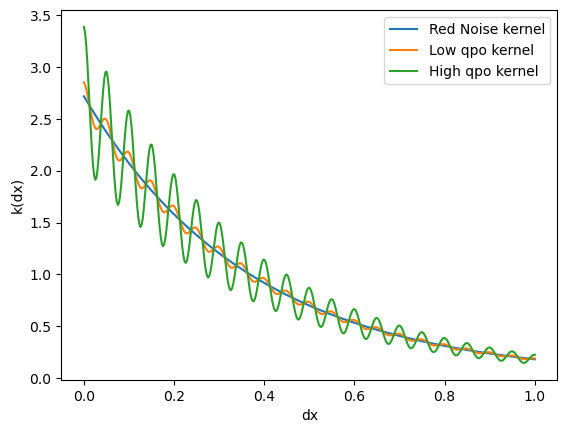

In [5]:
hqpoparams = {
    "arn" : jnp.exp(1.0),
    "crn" : jnp.exp(1.0),
    "aqpo": jnp.exp(-0.4),
    "cqpo": jnp.exp(1),
    "freq": 20,
}

# A higher hqpo 
# hqpoparams = {
#     "arn" : jnp.exp(1.0),
#     "crn" : jnp.exp(1.0),
#     "aqpo": jnp.exp(-0.1),
#     "cqpo": jnp.exp(1),
#     "freq": 20,
# }

hqpokernel = QPO_kernel(hqpoparams["arn"], hqpoparams["crn"],
                       hqpoparams["aqpo"], hqpoparams["cqpo"], hqpoparams["freq"])

""" Celerite kernel """

# hqpokernel = kernels.quasisep.Exp(
#     scale = 1/hqpoparams["crn"], sigma = (hqpoparams["arn"])**0.5) + kernels.quasisep.Celerite(
#         a = hqpoparams["aqpo"], b = 0.0, c = hqpoparams["cqpo"], d = hqpoparams["freq"])

plot_kernel(rnkernel, label="Red Noise kernel")
plot_kernel(lqpokernel, label="Low qpo kernel")
plot_kernel(hqpokernel, label="High qpo kernel")

Text(0, 0.5, 'M(x)')

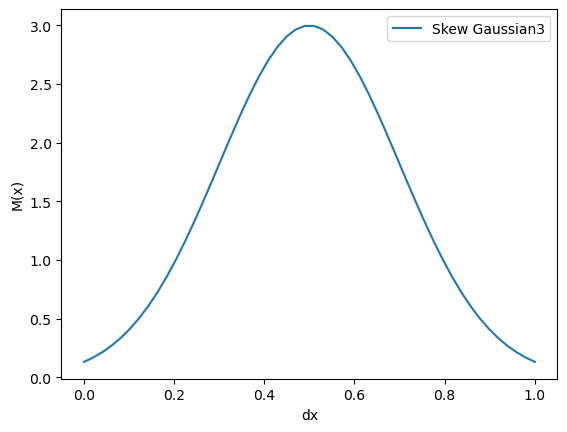

In [6]:
# Plotting the mean function:-

mean_params = {
    "A" : 3,
    "t0" : 0.5,
    "sig" : 0.2,
}

skew_gaussian3 = functools.partial(skew_gaussian2, mean_params = mean_params)

dx = np.linspace(0, 1, 50)
plt.plot(dx, skew_gaussian3(dx), label = "Skew Gaussian3")
# plt.plot(dx, skew_gaussian(dx), label = "Skew Gaussian")
plt.xlabel("dx")
plt.legend()
plt.ylabel("M(x)")

Text(0.5, 0, 'x')

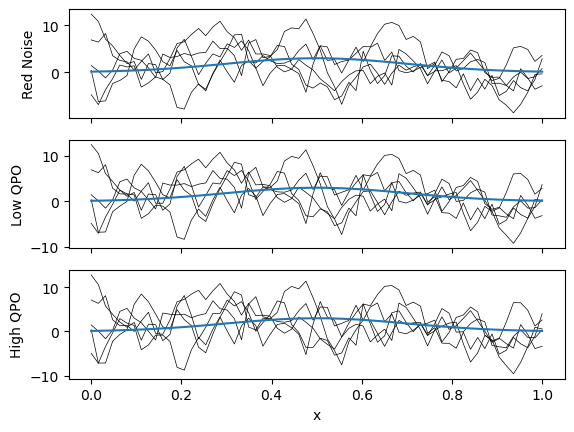

In [7]:
# Making the simulated data

# times = np.linspace(0, 1, 256)
# Shortened the duration of time to 1/4th of the original, 256/4 = 64
# times = np.linspace(0, 1/4, 64)

# Relongated to 1 s
times = np.linspace(0, 1, 64)

rngp = build_gp(rnparams, mean_params, times)
lqpop = build_gp(lqpoparams, mean_params, times)
hqpop = build_gp(hqpoparams, mean_params, times)

# rngp = build_gp2(rnparams, mean_params, times, kernel_type = "RN")
# lqpop = build_gp2(lqpoparams, mean_params, times, kernel_type = "QPO_plus_RN")
# hqpop = build_gp2(hqpoparams, mean_params, times, kernel_type = "QPO_plus_RN")

rngp_sample = rngp.sample(jax.random.PRNGKey(4), shape=(5,))
lqpogp_sample = lqpop.sample(jax.random.PRNGKey(4), shape=(5,))
hqpogp_sample = hqpop.sample(jax.random.PRNGKey(4), shape=(5,))

# Plotting these samples
_, axes = plt.subplots(3, 1, sharex=True)
ax = axes[0]
ax.plot(times, rngp_sample.T, color="k", lw=0.5)
ax.plot(times, jax.vmap(skew_gaussian)(times), label="mean")
ax.set_ylabel("Red Noise")

ax = axes[1]
ax.plot(times, lqpogp_sample.T, color="k", lw=0.5)
ax.plot(times, jax.vmap(skew_gaussian)(times), label="mean")
ax.set_ylabel("Low QPO")

ax = axes[2]
ax.plot(times, hqpogp_sample.T, color="k", lw=0.5)
ax.plot(times, jax.vmap(skew_gaussian)(times), label="mean")
ax.set_ylabel("High QPO")

ax.set_xlabel("x")

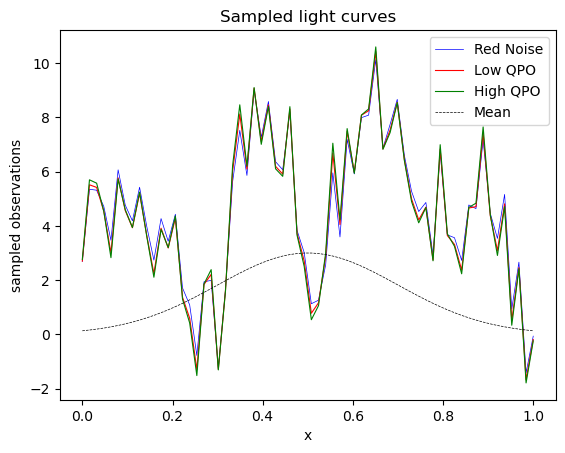

In [8]:
rngp_sample2   =  rngp.sample(jax.random.PRNGKey(5), shape=(1,))
lqpogp_sample2 = lqpop.sample(jax.random.PRNGKey(5), shape=(1,))
hqpogp_sample2 = hqpop.sample(jax.random.PRNGKey(5), shape=(1,))

plt.plot(times, rngp_sample2.T, lw=0.5,color = "b" ,label = "Red Noise")
plt.plot(times, lqpogp_sample2.T, lw=0.8, color = "r", label = "Low QPO")
plt.plot(times, hqpogp_sample2.T, lw=0.8, color = "g", label = "High QPO")
plt.plot(times, skew_gaussian3(times), color = "k", lw=0.5, ls = "--", label = "Mean")
plt.xlabel("x")
plt.ylabel("sampled observations")
plt.legend()
_ = plt.title("Sampled light curves")

# Why so similar, what about -ve elements? Similar even after changing kernel function

In [9]:
# Calculating evidences using jaxns
# Loading dependencies

import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp

from jaxns import ExactNestedSampler
from jaxns import TerminationCondition
from jaxns import analytic_log_evidence

tfpd = tfp.distributions

In [10]:
from jaxns import Prior, Model

# Defining the RN prior

def RNprior_model():
    # Is it log Normal or Uniform?
    # Feeding the values manually, should be put for lightcurve to lightcurve
    arn = yield Prior(tfpd.Uniform(0.0, 20.0), name='arn') # log uniform
    crn = yield Prior(tfpd.Uniform(1., 256/2), name='crn')
    # aqpo = yield Prior(tfpd.LogNormal(jnp.log(1.), 1.), name='aqpo')
    # cqpo = yield Prior(tfpd.LogNormal(jnp.log(1.), 1.), name='cqpo')
    # freq = yield Prior(tfpd.LogNormal(jnp.log(1.), 1.), name='freq')

    A = yield Prior(tfpd.Uniform(0.1*20, 2*20), name='A') # log uniform
    t0 = yield Prior(tfpd.Uniform(jnp.log(1.), 1.), name='t0')
    sig = yield Prior(tfpd.Uniform(jnp.log(1.), 1.), name='sig')

    return arn, crn, A, t0, sig # aqpo, cqpo, freq

# Defining the QPO prior,
# corner plots for rn higher
# lightcurve, with sampled parameters
# 

def QPOprior_model():
    arn = yield Prior(tfpd.Uniform(0.0, 20.0), name='arn')
    crn = yield Prior(tfpd.Uniform(1., 256/2), name='crn')
    # Should be Based on the lightcurve
    aqpo = yield Prior(tfpd.Uniform(0.0, 20.0), name='aqpo')
    # Should be dependent on the freq below (max value less than freq), Hense adjusting for that
    cqpo = yield Prior(tfpd.Uniform(0.1*1, 256/8), name='cqpo')
    freq = yield Prior(tfpd.Uniform(jnp.log(1.), 256/2), name='freq')

    A = yield Prior(tfpd.Uniform(0.1*20, 2*20), name='A')
    t0 = yield Prior(tfpd.Uniform(jnp.log(1.), 1.), name='t0')
    sig = yield Prior(tfpd.Uniform(jnp.log(1.), 1.), name='sig')

    return arn, crn, aqpo, cqpo, freq, A, t0, sig


In [11]:
hqpogp_sample3 = hqpop.sample(jax.random.PRNGKey(5))
print(type(hqpogp_sample3))
print(hqpogp_sample3.shape)
# Its a jaxlib array of size (1,256)

# Printing its log_likelihood, the shape has to be this

print(hqpop.log_probability(hqpogp_sample3))

<class 'jaxlib.xla_extension.ArrayImpl'>
(64,)
-146.30495415020408


In [12]:
# Will do it for a High QPO first

def RNlog_likelihood(arn, crn, A, t0, sig):
    rnlikelihood_params = {
        "arn": arn,
        "crn": crn,
        "aqpo": 0.0,
        "cqpo": 0.0,
        "freq": 0.0,
        }
    # Make a mean model, make the gp, and conditon on time and sample
    mean_params = {
        "A": A,
        "t0": t0,
        "sig": sig,
        }
    # Make the GP
    gp = build_gp(rnlikelihood_params, mean_params, times)
    # gp = build_gp2(rnlikelihood_params, mean_params, times, kernel_type = "RN")
    # Condition on the data, hense we will have to make a separate function for each data point
    return gp.log_probability(hqpogp_sample3)

def QPOlog_likelihood(arn, crn, aqpo, cqpo, freq,  A, t0, sig):
    qpolikelihood_params = {
        "arn": arn,
        "crn": crn,
        "aqpo": aqpo,
        "cqpo": cqpo,
        "freq": freq,
        }
    # Make a mean model, make the gp, and conditon on time and sample
    mean_params = {
        "A": A,
        "t0": t0,
        "sig": sig,
        }
    # Make the GP
    gp = build_gp(qpolikelihood_params, mean_params, times)
    # gp = build_gp2(qpolikelihood_params, mean_params, times, kernel_type = "QPO_plus_RN")
    # Condition on the data
    return gp.log_probability(hqpogp_sample3)

In [13]:
RNmodel = Model(prior_model= RNprior_model, log_likelihood=RNlog_likelihood)
RNmodel.sanity_check(random.PRNGKey(10), S = 100)

INFO[2023-07-05 19:21:47,737]: Sanity check...
INFO[2023-07-05 19:21:48,008]: Sanity check passed


In [14]:
RNexact_ns = ExactNestedSampler(RNmodel, num_live_points= 500,
                             max_samples= 1e4)

RNtermination_reason, RNstate = RNexact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))
RNresults = RNexact_ns.to_results(RNstate, RNtermination_reason)

In [51]:
RNexact_ns.summary(RNresults)

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 766582
# samples: 8652
# slices: 182000.0
# slices / acceptance: 26.0
# likelihood evals / sample: 88.6
# likelihood evals / slice: 4.2
--------
logZ=-151.33 +- 0.14
H=150.0
ESS=1522
--------
A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A: 5.7 +- 1.6 | 3.8 / 5.5 / 7.7 | 5.4 | 5.4
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: 2.18 +- 0.46 | 1.71 / 2.09 / 2.8 | 1.83 | 1.83
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 3.24 +- 0.76 | 2.5 / 3.31 / 3.84 | 3.64 | 3.64
--------
sig: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
sig: 0.51 +- 0.2 | 0.27 / 0.53 / 0.77 | 0.45 | 0.45
--------
t0: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
t0: 0.46 +- 0.18 | 0.2 / 0.47 / 0.66 | 0.44 | 0.44
--------


In [45]:
print(RNresults.log_Z_mean) # -158, excellent, -24 now

-151.33401020293823


In [50]:
from jaxns import analytic_log_evidence
# Took only 3m which is faster than Exact Nested Sampling
print(analytic_log_evidence(RNmodel, S = 10))

-38.887799751548755


In [46]:
QPOmodel = Model(prior_model= QPOprior_model, log_likelihood=QPOlog_likelihood)
QPOmodel.sanity_check(random.PRNGKey(10), S = 100)

INFO[2023-06-05 20:17:51,542]: Sanity check...
INFO[2023-06-05 20:17:51,556]: Sanity check passed


In [47]:
QPOexact_ns = ExactNestedSampler(QPOmodel, num_live_points= 500,
                             max_samples= 1e4)

QPOtermination_reason, QPOstate = QPOexact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))
QPOresults = QPOexact_ns.to_results(QPOstate, QPOtermination_reason)

# Took 9 minutes in intital run, 14 s after changing the kernel

In [50]:
QPOexact_ns.summary(QPOresults)

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 559434
# samples: 8652
# slices: 231000.0
# slices / acceptance: 33.0
# likelihood evals / sample: 64.7
# likelihood evals / slice: 2.4
--------
logZ=-149.99 +- 0.15
H=150.0
ESS=1521
--------
A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A: 5.2 +- 1.1 | 4.0 / 5.1 / 6.4 | 5.4 | 5.4
--------
aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
aqpo: 1.98 +- 0.55 | 1.37 / 1.96 / 2.63 | 1.58 | 1.58
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: 0.66 +- 0.47 | 0.18 / 0.6 / 1.06 | 0.57 | 0.57
--------
cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
cqpo: 2.2 +- 1.2 | 1.1 / 2.1 / 2.9 | 2.2 | 2.2
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 42.0 +- 25.0 | 11.0 / 41.0 / 67.0 | 15.0 | 15.0
--------
freq: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP 

In [49]:
print(QPOresults.log_Z_mean) # Just a small difference bw rn and qpo_rn, but still good

-149.9856382574008


In [21]:
# Will produce 10 samples and get the bayes factor for them
BF = np.zeros(30)

for i in range(30):
    print(f"Sample {i}")
    hqpogp_sample = hqpop.sample(jax.random.PRNGKey(i*i))
    print(hqpop.log_probability(hqpogp_sample))
    
    def RNlog_likelihood2(arn, crn, A, t0, sig):
        rnlikelihood_params = {
            "arn": arn,
            "crn": crn,
            "aqpo": 0.0,
            "cqpo": 0.0,
            "freq": 0.0,
            }
        # Make a mean model, make the gp, and conditon on time and sample
        mean_params = {
            "A": A,
            "t0": t0,
            "sig": sig,
            }
        # Make the GP
        # gp = build_gp(rnlikelihood_params, mean_params, times)
        gp = build_gp2(rnlikelihood_params, mean_params, times, kernel_type = "RN")
        # Condition on the data, hense we will have to make a separate function for each data point
        return gp.log_probability(hqpogp_sample)

    def QPOlog_likelihood2(arn, crn, aqpo, cqpo, freq,  A, t0, sig):
        qpolikelihood_params = {
            "arn": arn,
            "crn": crn,
            "aqpo": aqpo,
            "cqpo": cqpo,
            "freq": freq,
            }
        # Make a mean model, make the gp, and conditon on time and sample
        mean_params = {
            "A": A,
            "t0": t0,
            "sig": sig,
            }
        # Make the GP
        # gp = build_gp(qpolikelihood_params, mean_params, times)
        gp = build_gp2(qpolikelihood_params, mean_params, times, kernel_type = "QPO_plus_RN")
        # Condition on the data
        return gp.log_probability(hqpogp_sample)
    
    RNmodel = Model(prior_model= RNprior_model, log_likelihood=RNlog_likelihood2)
    RNexact_ns = ExactNestedSampler(RNmodel, num_live_points= 500,
                             max_samples= 1e4)
    RNtermination_reason, RNstate = RNexact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))
    RNresults = RNexact_ns.to_results(RNstate, RNtermination_reason)
    print(RNresults.log_Z_mean)

    QPOmodel = Model(prior_model= QPOprior_model, log_likelihood=QPOlog_likelihood2)
    QPOexact_ns = ExactNestedSampler(QPOmodel, num_live_points= 500,
                             max_samples= 1e4)
    QPOtermination_reason, QPOstate = QPOexact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))
    QPOresults = QPOexact_ns.to_results(QPOstate, QPOtermination_reason)
    print(QPOresults.log_Z_mean)

    BF[i] = QPOresults.log_Z_mean - RNresults.log_Z_mean
    

Sample 0
-19.405993936462693
-38.228235900475816
-42.57172058340193
Sample 1
-49.89475918913246
-64.28720238685997
-67.10545827663769
Sample 2
-18.758853615832763
-26.435265713640383
-37.07606313196213
Sample 3
-9.988204661210276
-21.605242785657484
-23.90528196154
Sample 4
-24.544981414060302
-36.40671351060959
-38.82000310079982
Sample 5
-41.142132462410615
-53.48913808737457
-55.87115483420525
Sample 6
-40.00892554326572
-43.83872820479598
-45.007461166142825
Sample 7
-33.94652735836465
-47.545962786670806
-53.024349892053806
Sample 8
-42.34786617791775
-50.46055239686053
-52.56119128504802
Sample 9
-31.854305986957
-47.260526501911016
-50.19268873580116
Sample 10
-32.42134777043637
-42.53218910629249
-44.83651526205629
Sample 11
-24.711624887833892
-35.76169789981203
-38.193324633890924
Sample 12
-41.667223305998476
-54.15311606596638
-56.33581854417223
Sample 13
-31.232355486577646
-40.98690405989657
-43.66793236162096
Sample 14
-25.192018098423034
-41.30626173800675
-43.797990804

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 3., 0., 1., 1., 3., 5., 8., 4., 0., 0., 3.]),
 array([-10.64079742, -10.31916909,  -9.99754076,  -9.67591243,
         -9.3542841 ,  -9.03265577,  -8.71102744,  -8.38939911,
         -8.06777079,  -7.74614246,  -7.42451413,  -7.1028858 ,
         -6.78125747,  -6.45962914,  -6.13800081,  -5.81637248,
         -5.49474415,  -5.17311582,  -4.8514875 ,  -4.52985917,
         -4.20823084,  -3.88660251,  -3.56497418,  -3.24334585,
         -2.92171752,  -2.60008919,  -2.27846086,  -1.95683253,
         -1.6352042 ,  -1.31357588,  -0.99194755]),
 <BarContainer object of 30 artists>)

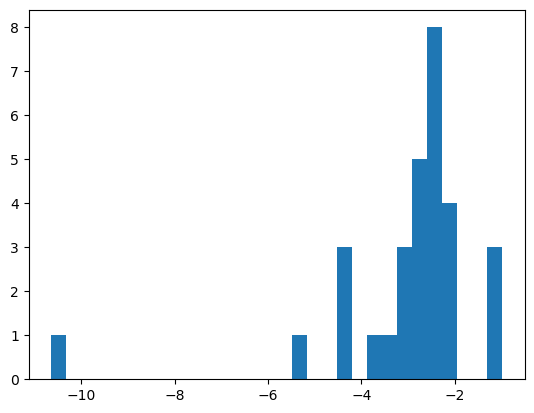

In [25]:
plt.hist(BF, bins = 30)

Trying out a low qpo sample

In [35]:
lqpogp_sample3 = lqpop.sample(jax.random.PRNGKey(4))
print(type(lqpogp_sample3))
print(lqpogp_sample3.shape)

print(lqpop.log_probability(lqpogp_sample3))

def RNlog_likelihood2(arn, crn, A, t0, sig):
    rnlikelihood_params = {
        "arn": arn,
        "crn": crn,
        "aqpo": 0.0,
        "cqpo": 0.0,
        "freq": 0.0,
        }
    # Make a mean model, make the gp, and conditon on time and sample
    mean_params = {
        "A": A,
        "t0": t0,
        "sig": sig,
        }
    # Make the GP
    # gp = build_gp(rnlikelihood_params, mean_params, times)
    gp = build_gp2(rnlikelihood_params, mean_params, times, kernel_type = "RN")
    # Condition on the data, hense we will have to make a separate function for each data point
    return gp.log_probability(lqpogp_sample3)

def QPOlog_likelihood2(arn, crn, aqpo, cqpo, freq,  A, t0, sig):
    qpolikelihood_params = {
        "arn": arn,
        "crn": crn,
        "aqpo": aqpo,
        "cqpo": cqpo,
        "freq": freq,
        }
    # Make a mean model, make the gp, and conditon on time and sample
    mean_params = {
        "A": A,
        "t0": t0,
        "sig": sig,
        }
    # Make the GP
    # gp = build_gp(rnlikelihood_params, mean_params, times)
    gp = build_gp2(qpolikelihood_params, mean_params, times, kernel_type = "QPO_plus_RN")
    # Condition on the data
    return gp.log_probability(lqpogp_sample3)

# Why is it +ve ??

<class 'jaxlib.xla_extension.ArrayImpl'>
(256,)
5.999702677353525


In [36]:
RNmodel = Model(prior_model= RNprior_model, log_likelihood=RNlog_likelihood2)
RNmodel.sanity_check(random.PRNGKey(10), S = 100)

INFO[2023-06-01 14:31:49,970]: Sanity check...
INFO[2023-06-01 14:31:49,972]: Sanity check passed


In [37]:
RNexact_ns = ExactNestedSampler(RNmodel, num_live_points= 500,
                             max_samples= 1e4)

RNtermination_reason, RNstate = RNexact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))
RNresults = RNexact_ns.to_results(RNstate, RNtermination_reason)

print(RNresults.log_Z_mean)

-2.4232280430628554


In [38]:
from jaxns import analytic_log_evidence
# Took only 3m which is faster than Exact Nested Sampling
print(analytic_log_evidence(RNmodel, S = 10))

-0.2715897549454098


In [39]:
QPOexact_ns = ExactNestedSampler(QPOmodel, num_live_points= 500,
                             max_samples= 1e4)

QPOtermination_reason, QPOstate = QPOexact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))
QPOresults = QPOexact_ns.to_results(QPOstate, QPOtermination_reason)

print(QPOresults.log_Z_mean)

-67.28905153382912


Try some other non sense kernel